In [36]:
import random
import numpy as np
import networkx as nx 
from dijkstar import Graph, find_path
from ipywidgets import IntProgress 
from IPython.display import display

In [37]:
def get_complete_path(path, all_paths):
  complete_path = []
  for i in range(len(path) - 1):
    complete_path.extend(all_paths[(path[i], path[i+1])][:-1])
    if i == len(path) - 2:
      complete_path.append(all_paths[(path[i], path[i+1])][-1])
  return complete_path

def is_path_in_interval(path, complete_graph, interval, interval_vertex):
  weight = 0
  for i in range(np.where(np.array(path) == interval_vertex)[0][0]):
    weight += complete_graph[path[i]][path[i+1]]
  if weight >= interval[0] and weight <= interval[1]:
    return True
  else:
    return False

In [38]:
population_number = 500
generation_number = 500

In [39]:
def get_path_weight(path, complete_graph):
  weight = 0
  for i in range(len(path) - 1):
    weight += complete_graph[path[i]][path[i+1]]
  return weight

def generate_population(nb_people, complete_graph, interval, interval_vertex, start_vertex):
  population = []
  while(len(population) < nb_people):
    path = generate_random_path(len(complete_graph), start_vertex)
    if is_path_in_interval(path, complete_graph, interval, interval_vertex):
      population.append(path)
  return population

def get_best_path(population, weights):
  index = np.argmin(weights)
  return population[index], weights[index]


In [40]:
def mutate_path_insert(path, complete_graph, interval, interval_vertex):
  is_path_correct = False
  while not is_path_correct:
    start = path[0]
    path = np.delete(path, np.where(path == start))
    mutation = random.choice(path)
    path = np.delete(path, np.where(path == mutation))
    new_index = random.randint(0, len(path) - 1)
    path = np.insert(path, new_index, mutation)
    path = np.append(path, start)
    path = np.insert(path, 0, start)
    is_path_correct = is_path_in_interval(path, complete_graph, interval, interval_vertex)
  return path

def generate_children(parentA, parentB, complete_graph, interval, interval_vertex):
  start = parentA[0]
  parentA = np.delete(parentA, np.where(np.array(parentA) == start))
  parentB = np.delete(parentB, np.where(np.array(parentB) == start))
  is_path_correct = False
  while not is_path_correct:
    cut_start = random.randint(0, len(parentA) - 2)
    cut_end = random.randint(cut_start + 1, len(parentA) - 1)
    child = parentA[cut_start:cut_end]
    for i in child:
      remaining_parentB = np.delete(parentB, np.where(parentB == i))
    child = np.insert(child, len(child), remaining_parentB)
    child = np.append(child, start)
    child = np.insert(child, 0, start)
    is_path_correct = is_path_in_interval(child, complete_graph, interval, interval_vertex)
  return child

def generate_random_path(nb_vertex, start_vertex):
  path = np.arange(nb_vertex)
  path = np.delete(path, np.where(path == start_vertex))
  np.random.shuffle(path)
  path = np.append(path, start_vertex)
  path = np.insert(path, 0, start_vertex)
  return path

def get_best_population(population):
  return np.argpartition(population, -int(len(population)/4))[:int(len(population)/4)]

def generate_decency(population_number, best_people, complete_graph, interval, interval_vertex_index):
  children = []
  for _ in range(population_number):
    P1 = random.choice(best_people)
    # child = generate_children(P1, P2, complete_graph, interval, interval_vertex_index)
    child = mutate_path_insert(P1, complete_graph, interval, interval_vertex_index)
    children.append(child)
  return children

def evalute_population_weight(population, complete_graph):
  weights = []
  for path in population:
    weight = get_path_weight(path, complete_graph)
    weights.append(weight)
  return weights

def evolve(population, complete_graph, interval, interval_vertex_index):
  best_weight = np.inf
  best_path = []
  all_best_weights = np.array([])
  bar = IntProgress(min=0, max=generation_number, layout={"width" : "100%"})
  display(bar)
  for i in range(generation_number):
    bar.value += 1
    weights = evalute_population_weight(population, complete_graph)
    best_pop_path, best_pop_weight = get_best_path(population, weights)
    all_best_weights = np.append(all_best_weights,best_pop_weight)
    if(best_pop_weight < best_weight):
      best_weight = best_pop_weight
      best_path = best_pop_path
    best_people = np.array(population)[get_best_population(weights)]
    population = generate_decency(population_number, best_people, complete_graph, interval, interval_vertex_index)
  bar.close()
  return best_path, best_weight, all_best_weights

In [41]:
import pickle
with open("data.pickle", "rb") as file:
  data = pickle.load(file)

graph = data["graph"]
complete_graph = data["complete_graph"]
all_paths = data["all_paths"]
vertices_list = data["vertices_list"]
start_vertex = data["start_vertex"]
start_vertex_index = data["start_vertex_index"]
interval_vertex = data["interval_vertex"]
interval_vertex_index = data["interval_vertex_index"]
interval = data["interval"]

population = generate_population(population_number, complete_graph, interval, interval_vertex_index, start_vertex_index)
best_path, best_weight, all_best_weights = evolve(population, complete_graph, interval, interval_vertex_index)
print(best_path, best_weight)

graph:  [[inf inf inf ... 25. inf 25.]
 [inf inf inf ... 26. 47. 42.]
 [inf inf inf ... inf 33. inf]
 ...
 [25. 26. inf ... inf 51. 44.]
 [inf 47. 33. ... 51. inf inf]
 [25. 42. inf ... 44. inf inf]]
complete_graph:  [[ 0. 31. 13. ... 28. 50. 41.]
 [31.  0. 25. ... 31. 43. 40.]
 [13. 25.  0. ... 31. 39. 30.]
 ...
 [28. 31. 31. ...  0. 26. 29.]
 [50. 43. 39. ... 26.  0. 34.]
 [41. 40. 30. ... 29. 34.  0.]]
all_paths:  {(0, 1): [42, 10, 27], (0, 2): [42, 72], (0, 3): [42, 72, 66], (0, 4): [42, 10], (0, 5): [42, 94, 9], (0, 6): [42, 72, 60, 78], (0, 7): [42, 1], (0, 8): [42, 12], (0, 9): [42, 50], (0, 10): [42, 72, 45], (0, 11): [42, 99, 83], (0, 12): [42, 72, 74], (0, 13): [42, 7, 69], (0, 14): [42, 35, 29], (0, 15): [42, 2], (0, 16): [42, 95, 34], (0, 17): [42, 99, 71, 26], (0, 18): [42, 17], (0, 19): [42, 38], (0, 20): [42, 44], (0, 21): [42, 7], (0, 22): [42, 70], (0, 23): [42, 72, 80], (0, 24): [42, 3, 96], (0, 25): [42, 94, 64], (0, 26): [42, 85, 4], (0, 27): [42, 67, 53], (0, 28): 

IntProgress(value=0, layout=Layout(width='100%'), max=500)

[46 16  6 24 48 44 25 17 45 28 20  8 27 10 19  4  0 21  7 32 35 34 31 30
 43 18 15  3  2 23 13 11 39 12  1 26  5 37 42 29 47 40 41 22 38  9 14 36
 33 49 46] 1055.0


Text(0, 0.5, 'weight')

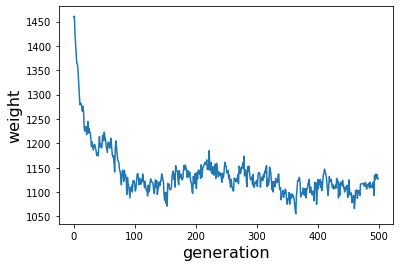

In [42]:
import matplotlib.pyplot as plt

res = plt.plot(range(len(all_best_weights)), all_best_weights)
plt.xlabel("generation", fontsize=16)
plt.ylabel("weight", fontsize=16)